In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor as Xgb
from sklearn.ensemble import RandomForestRegressor
#SKforecast
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    grid_search_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.plot import set_dark_theme
from skforecast.feature_selection import select_features_multiseries

#SKLEARN
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

#MLFLOW
import mlflow
from mlflow.tracking import MlflowClient
import pickle

#Exogenous variables 
import holidays
from vacances_scolaires_france import SchoolHolidayDates

In [ ]:
#vacances scolaires
d = SchoolHolidayDates()
dates_vacances=set()
for y in (2023,2024):
    vacances=d.holidays_for_year_and_zone(y, 'C')
    dates_vacances.update(vacances.keys())

#jours feriés
feries = holidays.France(years=['2023','2024'])

In [ ]:
data = pd.read_csv("lit_cluster_0.csv",index_col="date_semaine", parse_dates=True)
data=data.asfreq('W') 
list_uf =data.columns.tolist()

data['vacances']= data.index.isin(dates_vacances).astype(int)
data['feries'] = data.index.isin(feries).astype(int)
data["month"] = data.index.month
data["day_of_week"] = data.index.dayofweek
data["day_of_month"] = data.index.day
data["week_of_year"] = data.index.isocalendar().week

exog_list=data.columns.drop(list_uf)

In [ ]:
n_samples = len(data)
train_size = int(0.6 * n_samples)  
val_size = int(0.2 * n_samples)  

data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

print(f"Total samples: {n_samples}")
print(f"Train: {len(data_train)} samples : {data_train.index[0]} to {data_train.index[-1]}")
print(f"Validation: {len(data_val)} samples : {data_val.index[0]} to {data_val.index[-1]}")
print(f"Test: {len(data_test)} samples : {data_test.index[0]} to {data_test.index[-1]}")

In [ ]:
col="1015"
set_dark_theme()
plt.figure(figsize=(12, 4))
 
data_train[col].plot( label='train')
data_val[col].plot( label='validation')
data_test[col].plot( label='test')
plt.show()

In [ ]:
# Create and train ForecasterRecursiveMultiSeries
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = RandomForestRegressor(n_estimators=100, random_state=42),
                 lags               = 52,
                 window_features    = RollingFeatures(stats=['mean', 'mean','mean','std','std','std'], window_sizes=[4, 24, 52, 4, 24, 52]),
                 encoding           = 'ordinal'
             )

forecaster.fit(series=data_train[list_uf],
               exog=data_train[exog_list],
                store_in_sample_residuals=True)


In [ ]:
cv = TimeSeriesFold(
         steps              = 21,
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size=True
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = data.iloc[:train_size + val_size][list_uf],
    exog                  = data.iloc[:train_size + val_size][exog_list],
    cv                    = cv,
    levels                = None,
    metric                = 'mean_absolute_error',
    add_aggregated_metric = True
)

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

In [ ]:

tscv = TimeSeriesSplit(n_splits=3)
regressor = LGBMRegressor(n_estimators=100, max_depth=5, random_state=15926, verbose=-1)
selector = RFECV(estimator=regressor, step=1, cv=tscv, min_features_to_select=1,scoring='neg_mean_absolute_error')
selected_lags, selected_window_features, selected_exog = select_features_multiseries(
    forecaster      = forecaster,
    selector        = selector,
    series          = data.iloc[:train_size+val_size][list_uf],
    exog            = data.iloc[:train_size+val_size][exog_list],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = False,
)

In [ ]:
stats=[]
window_sizes=[]
for i, value in enumerate(selected_window_features):
    stats.append(selected_window_features[i].split("_")[1])
    window_sizes.append(int(selected_window_features[i].split("_")[2]))

forecaster.set_lags(lags=selected_lags)
forecaster.set_window_features(window_features=RollingFeatures(stats=stats, window_sizes=window_sizes))

In [ ]:
levels = list_uf

# Search space
def search_space(trial):
    search_space = {
        # Core Random Forest parameters
        'n_estimators'      : trial.suggest_int('n_estimators', 100, 1000),
        'max_depth'         : trial.suggest_int('max_depth', 3, 20),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 10),
        
        # Feature selection parameters
        'max_features'      : trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_samples'       : trial.suggest_float('max_samples', 0.5, 1.0),
        
        # Tree building parameters
        'bootstrap'         : trial.suggest_categorical('bootstrap', [True, False]),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.1),
        'max_leaf_nodes'    : trial.suggest_int('max_leaf_nodes', 10, 1000),
        
        # Complexity control
        'ccp_alpha'         : trial.suggest_float('ccp_alpha', 0.0, 0.1)
    }

    return search_space

cv = TimeSeriesFold(
         steps              = 21,
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size=False
     )

results, best_trial = bayesian_search_forecaster_multiseries(
    forecaster       = forecaster,
    series           = data.iloc[:train_size+val_size][list_uf],
    exog             = data.iloc[:train_size+val_size][selected_exog],
    search_space     = search_space,
    cv               = cv,
    levels           = list_uf,
    metric           = 'mean_absolute_error',
    aggregate_metric = ['weighted_average', 'average', 'pooling'],
    n_trials         = 5
)



In [ ]:
forecaster.fit(
    series = data.iloc[:train_size+val_size][list_uf],
    exog= data.iloc[:train_size+val_size][selected_exog],
    store_in_sample_residuals=True
)

In [23]:

preds = forecaster.predict(steps=21, exog=data.iloc[train_size+val_size:][selected_exog])
maes=[]
for col in list_uf:
    mae = mean_absolute_error(data_test[col], preds[preds['level']==col]['pred'])
    maes.append(mae)
mmae = np.mean(maes)
print(f"Mean Absolute Error for cluster 1: {mmae:.2f}")

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ `last_window` has missing values. Most of machine learning models do not allow       │
│ missing values. Prediction method may fail.                                          │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\Users\yessi\anaconda3\envs\new_env\Lib\site-packages\skforecast\utils\utils.py:98 │
│ 9                                                                                    │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : DataTypeWarning                                                           │
│ Location :                                                                           │
│ c:\Users\yessi\anaconda3\envs\new_env\Lib\site-packages\skforecast\utils\utils.py:63 │
│ 8                                                                                    │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Mean Absolute Error for cluster 1: 1.07


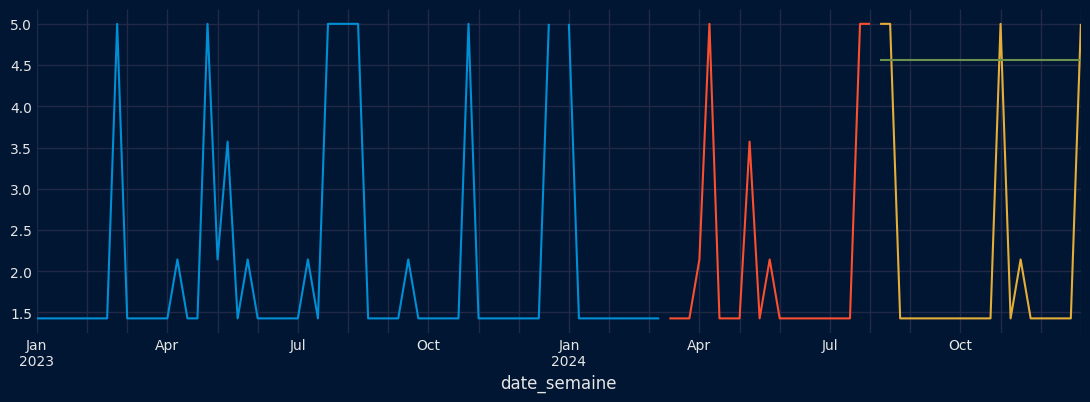

In [24]:
col="1015"
set_dark_theme()
plt.figure(figsize=(12, 4))
 
data_train[col].plot( label='train')
data_val[col].plot( label='validation')
data_test[col].plot( label='test')
preds[preds['level']==col]['pred'].plot(label='prediction')
plt.show()

In [25]:
mlflow.set_experiment("Default")
mlflow.set_tracking_uri("http://127.0.0.1:5000")

params = forecaster.regressor.get_params()
params['lags'] = forecaster.lags
params['window features'] = forecaster.window_features
params['exogs'] = forecaster.exog_names_in_
params['regressor'] = forecaster.regressor.__class__.__name__

with mlflow.start_run(run_name='RF_final_c0') as run:
    mlflow.log_params(params)
    mlflow.log_metrics({"MMAE test" : 1.07})
    # Save forecaster object as pickle
    with open("RF_final_c0.pkl", "wb") as f:
        pickle.dump(forecaster, f)

    # Log the pickle file as an artifact
    mlflow.log_artifact("RF_final_c0.pkl", artifact_path="pickle_folder")

🏃 View run RF_final_c0 at: http://127.0.0.1:5000/#/experiments/0/runs/3968b90c5cbf49ed93474ed895cc9f02
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
